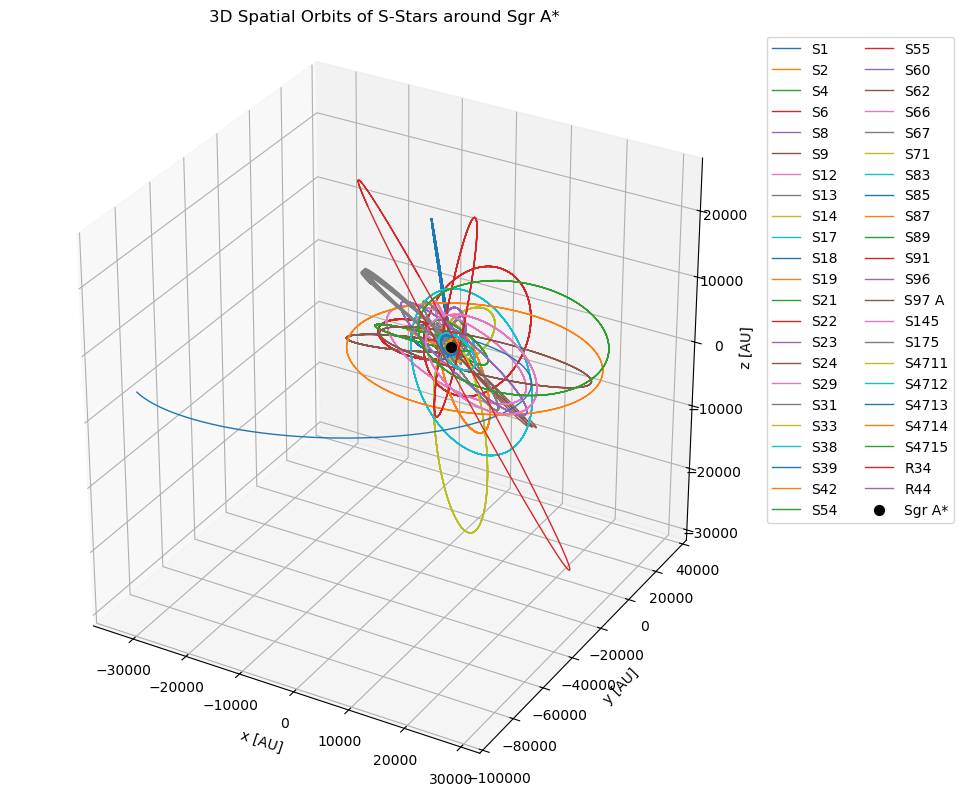

In [19]:
import numpy as np
import pandas as pd
import reboundx
import rebound
import math
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Physical constants & load CSV
# -----------------------------------------------------------------------------
G      = 6.67430e-11      # SI: m^3 kg^-1 s^-2
c      = 3.0e8            # m/s
M_sun  = 1.989e30         # kg
AU     = 1.496e11         # m
year   = 3.154e7          # s
D_pc   = 8266.0           # distance to GC in parsec
M_BH   = 4.154e6 * M_sun  # Sgr A* mass

# Load cluster data
df = pd.read_csv('/Users/pythagoraslu/Desktop/black hole/cluster data.csv')
ids      = df['id1'].tolist()
N        = len(ids)

bad_indices = {8, 25, 37}

# Orbital elements from your table
e_arr     = df['e'].to_numpy()
a_arc_arr = df['a'].to_numpy()        # semimajor axis [arcsec]
Omega_deg_arr  = df['omega1'].to_numpy()   # Ω in degrees
i_deg_arr      = df['i'].to_numpy()        # i in degrees
omega_deg_arr  = df['omega2'].to_numpy()   # ω in degrees
v_pct_arr = df['v (%c)'].to_numpy()   # speed at pericenter (% of c)
P_yr_arr  = df['P (yr)'].to_numpy()   # orbital periods [yr]
mass_arr  = df['Mass (Solar masses)'].fillna(10.0).to_numpy() * M_sun

a_m_arr = a_arc_arr * D_pc * AU  # Convert semimajor axes from arcsec to meters

# Override v_pct_arr with Keplerian values for problematic stars
for i in bad_indices:
    e = e_arr[i]
    a_m = a_m_arr[i]
    r0 = a_m * (1 - e)
    v_kep = np.sqrt(G * M_BH * (1 + e) / r0)
    v_pct_arr[i] = v_kep / c * 100  # convert to %c

# Total integration time (seconds)
t_final = P_yr_arr.max() * year

# -----------------------------------------------------------------------------
# 2) Build the Rebound sim
# -----------------------------------------------------------------------------
sim = rebound.Simulation()
sim.G = G
sim.units = ['kg','m','s']
sim.integrator = "ias15"

# Add the central black hole
sim.add(m=M_BH, x=0, y=0, z=0, vx=0, vy=0, vz=0)

# Attach REBOUNDx
rebx = reboundx.Extras(sim)

# Load and add the general relativity force (1PN correction)
gr = rebx.load_force("gr")
rebx.add_force(gr)
gr.params["c"] = c


# Add stars
for i in range(N):

    if i == 41: 
        continue

    # orbital elements
    a_m   = a_m_arr[i]
    e     = e_arr[i]
    r0    = a_m * (1 - e)                # pericenter distance
    v0    = (v_pct_arr[i]/100) * c       # pericenter speed

    # the three angles for this star
    Ω   = Omega_deg_arr[i]
    inc = i_deg_arr[i]
    ω   = omega_deg_arr[i]

    # base vectors in the orbital plane at f=0
    r_orb = np.array([ r0,      0.0, 0.0 ])
    v_orb = np.array([ 0.0,     v0,  0.0 ])

    # precompute sines/cosines
    cO, sO = math.cos(Ω), math.sin(Ω)
    ci, si = math.cos(inc), math.sin(inc)
    cw, sw = math.cos(ω), math.sin(ω)

    # build the rotation matrices
    R_ω = np.array([[ cw, -sw, 0],
                    [ sw,  cw, 0],
                    [  0,   0, 1]])
    R_i = np.array([[  1,   0,   0],
                    [  0,  ci, -si],
                    [  0,  si,  ci]])
    R_Ω = np.array([[ cO, -sO, 0],
                    [ sO,  cO, 0],
                    [  0,   0, 1]])

    # full rotation
    R = R_Ω.dot(R_i.dot(R_ω))

    # inertial coords
    r_vec = R.dot(r_orb)
    v_vec = R.dot(v_orb)

    
    # add to the sim
    sim.add(
        m  = mass_arr[i],
        x  = r_vec[0],  y  = r_vec[1],  z  = r_vec[2],
        vx = v_vec[0],  vy = v_vec[1],  vz = v_vec[2]
    )


# Center-of-mass correction
sim.move_to_com()

# -----------------------------------------------------------------------------
# 3) Integrate positions over time
# -----------------------------------------------------------------------------
n_steps = 5000
times   = np.linspace(0.0, t_final, n_steps)

pos  = np.zeros((n_steps, N, 3), dtype=float)
vel  = np.zeros((n_steps, N, 3), dtype=float)

for k, t in enumerate(times):
    sim.integrate(t)
    for star_idx, p in enumerate(sim.particles[1:]):
        pos[k, star_idx, 0] = p.x
        pos[k, star_idx, 1] = p.y
        pos[k, star_idx, 2] = p.z
        vel[k, star_idx, 0] = p.vx
        vel[k, star_idx, 1] = p.vy
        vel[k, star_idx, 2] = p.vz

# -----------------------------------------------------------------------------
# 4) Plot 3D orbits
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection='3d')

for i, name in enumerate(ids):
    xs = pos[:, i, 0] / AU
    ys = pos[:, i, 1] / AU
    zs = pos[:, i, 2] / AU
    ax.plot(xs, ys, zs, label=name, linewidth=1)

ax.scatter(0, 0, 0, c='k', s=50, label='Sgr A*')
ax.set_box_aspect((1,1,1))
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('3D Spatial Orbits of S-Stars around Sgr A*')
ax.legend(ncol=2, bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()